In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/LI-Small_Trans.csv
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/HI-Large_Trans.csv
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/HI-Medium_Trans.csv
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/HI-Small_Patterns.txt
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/HI-Medium_Patterns.txt
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/LI-Medium_Trans.csv
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/HI-Large_Patterns.txt
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/LI-Medium_Patterns.txt
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/LI-Large_Patterns.txt
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/LI-Large_Trans.csv
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/LI-Small_Patterns.txt
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/HI-Small_Trans.csv


In [3]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 558.9 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import datetime
import os
from typing import Callable, Optional
import pandas as pd
from sklearn import preprocessing
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from torch_geometric.data import (
    Data,
    InMemoryDataset
)

In [5]:
pd.set_option('display.max_columns', None)
path1 = '/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/HI-Medium_Trans.csv'
path2 = '/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/HI-Small_Trans.csv'
path3 = '/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/LI-Medium_Trans.csv'
path4 = '/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/LI-Small_Trans.csv'
df1 = pd.read_csv(path1)
df2 = pd.read_csv(path2)
df3 = pd.read_csv(path3)
df4 = pd.read_csv(path4)

In [6]:
df5 = df1[df1['Is Laundering'] == 1]
df6 = df3[df3['Is Laundering'] == 1]
df7 = df4[df4['Is Laundering'] == 1]

#### **Let's Concatenate the two datasets** 

In [7]:
df = pd.concat([df2, df5, df6, df7], ignore_index=True)

#### **Shuffle the prepared dataset `df` to remove data biasness**

In [8]:
# Import Function shuffle  
from sklearn.utils import shuffle
df = shuffle(df).reset_index(drop=True)

## **Data Visualization**

In [9]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/05 12:02,70,100428660,2843,8013F24E0,297.20,US Dollar,297.20,US Dollar,Credit Card,0
1,2022/09/01 17:31,2133655,832677D20,2117586,832677DC0,895.55,Australian Dollar,895.55,Australian Dollar,ACH,1
2,2022/09/01 20:44,5627,802F9AD90,19705,8080AA370,1643.93,Yuan,1643.93,Yuan,Cheque,0
3,2022/09/01 08:34,22828,802438240,11157,805CDE900,181265.98,US Dollar,181265.98,US Dollar,Cheque,0
4,2022/09/09 12:13,28222,80A5CB130,127593,80A738EB0,234.99,Australian Dollar,234.99,Australian Dollar,Credit Card,0


In [10]:
df.dtypes

Timestamp              object
From Bank               int64
Account                object
To Bank                 int64
Account.1              object
Amount Received       float64
Receiving Currency     object
Amount Paid           float64
Payment Currency       object
Payment Format         object
Is Laundering           int64
dtype: object

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5133181 entries, 0 to 5133180
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Account             object 
 3   To Bank             int64  
 4   Account.1           object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 430.8+ MB


In [12]:
df.nunique()

Timestamp              25500
From Bank              38812
Account               532132
To Bank                25527
Account.1             464719
Amount Received       950531
Receiving Currency        15
Amount Paid           959142
Payment Currency          15
Payment Format             7
Is Laundering              2
dtype: int64

#### **Check for Null Values**

In [13]:
df.isnull().sum()

Timestamp             0
From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
dtype: int64

#### **Let's check for any difference between `paid amount` and `received amount`**

In [14]:
print("Amount received equals to Amount Paid:")
print(df['Amount Received'].equals(df['Amount Paid']))

Amount received equals to Amount Paid:
False


#### **Let's check whether `Recieving Currency` equals to `Payment Currency`**

In [15]:
print('Receiving Currency equals to Payment Currency:')
print(df['Receiving Currency'].equals(df['Payment Currency']))

Receiving Currency equals to Payment Currency:
False


#### **Let's find out the transactions with `not equal amount` and `not equal currency`**

In [16]:
not_equal_amount = df.loc[~(df['Amount Received'] == df['Amount Paid'])]
not_equal_currency = df.loc[~(df['Receiving Currency'] == df['Payment Currency'])]

print("Total Transactions: ", len(df))
print("Not Equal Amount Transactions Total: ", len(not_equal_amount))
print("Not Equal Currency Transactions Total: ", len(not_equal_currency))

Total Transactions:  5133181
Not Equal Amount Transactions Total:  72158
Not Equal Currency Transactions Total:  72170


In [17]:
filtered_df = df[df['Receiving Currency'] != df['Payment Currency']]
filtered_df

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
91,2022/09/13 11:37,214749,805DB7F20,214749,805DB7F20,9652.37,US Dollar,708908.80,Rupee,ACH,0
147,2022/09/01 15:20,13029,804C9DF20,13029,804C9DF20,23.09,US Dollar,1696.17,Rupee,ACH,0
182,2022/09/05 15:00,1362,801B75120,1362,801B75120,19.81,UK Pound,25.59,US Dollar,ACH,0
238,2022/09/03 00:29,48211,811A71520,48211,811A71520,727.70,Mexican Peso,129.10,Saudi Riyal,ACH,0
245,2022/09/08 12:09,1267,8023598B0,1267,8023598B0,85084.76,US Dollar,569863.66,Yuan,ACH,0
...,...,...,...,...,...,...,...,...,...,...,...
5132737,2022/09/06 06:39,2627,80A4A4790,2627,80A4A4790,11720.20,Shekel,3470.60,US Dollar,ACH,0
5132922,2022/09/04 02:00,18067,80366B870,18067,80366B870,13.40,US Dollar,89.77,Yuan,ACH,0
5132940,2022/09/05 00:25,16109,8099EB150,16109,8099EB150,4.19,Euro,4.91,US Dollar,ACH,0
5132948,2022/09/10 00:04,1292,800761C60,1292,800761C60,5269.07,Yen,49.99,US Dollar,ACH,0


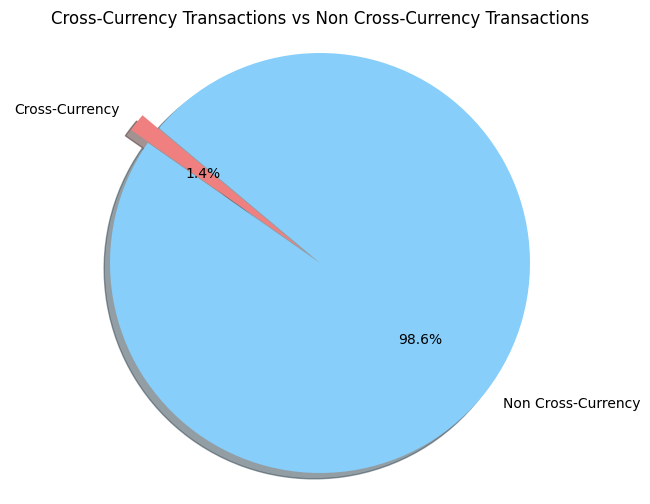

In [18]:
cross_currency_count = len(filtered_df)

total_transactions = len(df)

non_cross_currency_count = total_transactions - cross_currency_count

labels = ['Cross-Currency', 'Non Cross-Currency']
sizes = [cross_currency_count, non_cross_currency_count]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Cross-Currency Transactions vs Non Cross-Currency Transactions')
plt.axis('equal')
plt.show()

#### **Let's find out what are the Different `Currency` Types**

In [19]:
print(sorted(df['Receiving Currency'].unique()))
print(sorted(df['Payment Currency'].unique()))

['Australian Dollar', 'Bitcoin', 'Brazil Real', 'Canadian Dollar', 'Euro', 'Mexican Peso', 'Ruble', 'Rupee', 'Saudi Riyal', 'Shekel', 'Swiss Franc', 'UK Pound', 'US Dollar', 'Yen', 'Yuan']
['Australian Dollar', 'Bitcoin', 'Brazil Real', 'Canadian Dollar', 'Euro', 'Mexican Peso', 'Ruble', 'Rupee', 'Saudi Riyal', 'Shekel', 'Swiss Franc', 'UK Pound', 'US Dollar', 'Yen', 'Yuan']


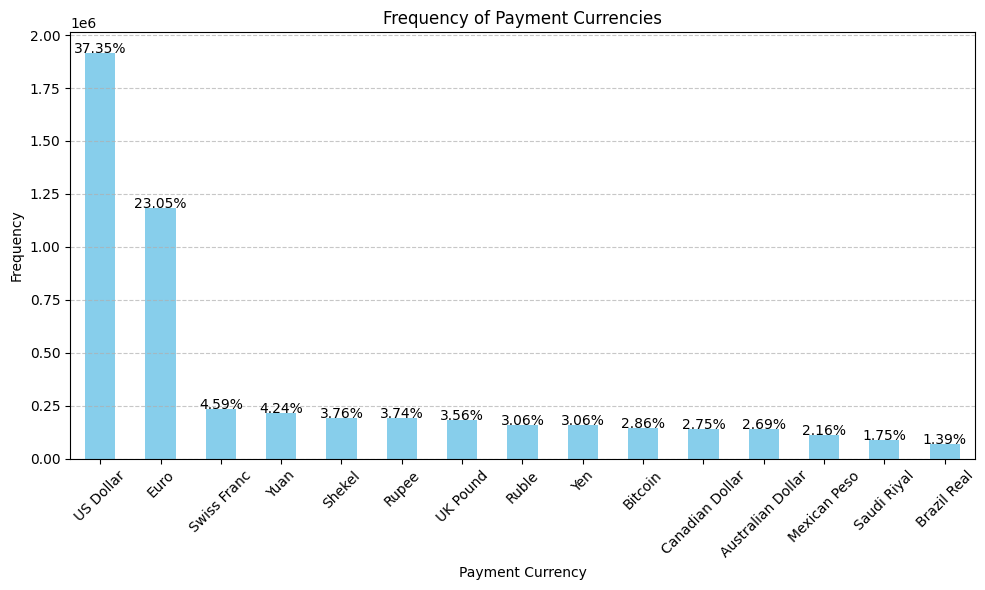

In [20]:
currency_counts = df['Payment Currency'].value_counts()
total_transactions = len(df)
currency_percentage = (currency_counts / total_transactions) * 100

plt.figure(figsize=(10, 6))
bars = currency_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Payment Currencies')
plt.xlabel('Payment Currency')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(currency_counts):
    plt.text(i, v + 0.5, f'{currency_percentage.iloc[i]:.2f}%', ha='center')

plt.tight_layout()
plt.show()

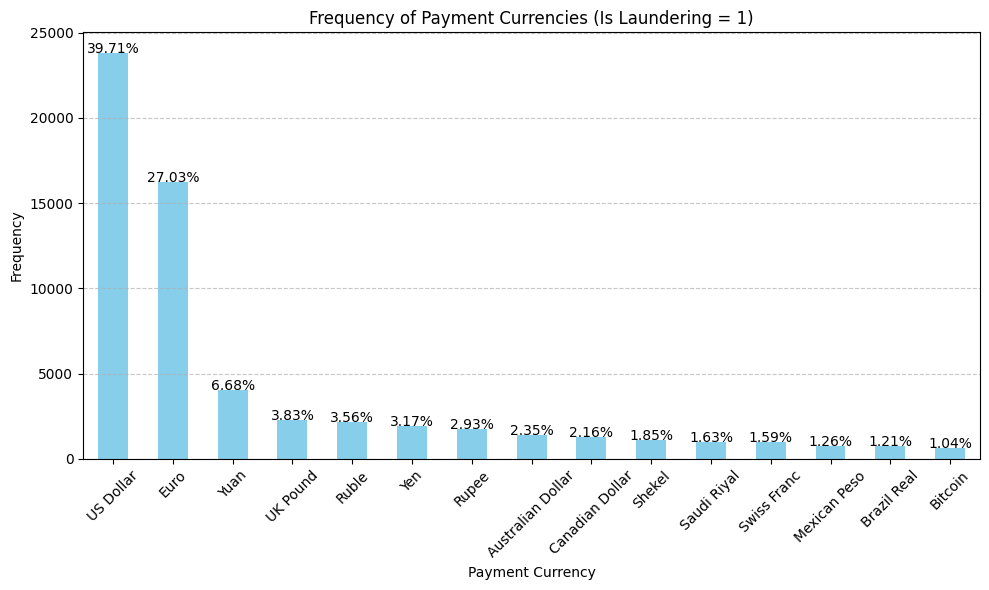

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

laundering_df = df[df['Is Laundering'] == 1]

currency_counts = laundering_df['Payment Currency'].value_counts()

total_transactions = len(laundering_df)
currency_percentage = (currency_counts / total_transactions) * 100

plt.figure(figsize=(10, 6))
bars = currency_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Payment Currencies (Is Laundering = 1)')
plt.xlabel('Payment Currency')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(currency_counts):
    plt.text(i, v + 0.5, f'{currency_percentage.iloc[i]:.2f}%', ha='center')

plt.tight_layout()
plt.show()

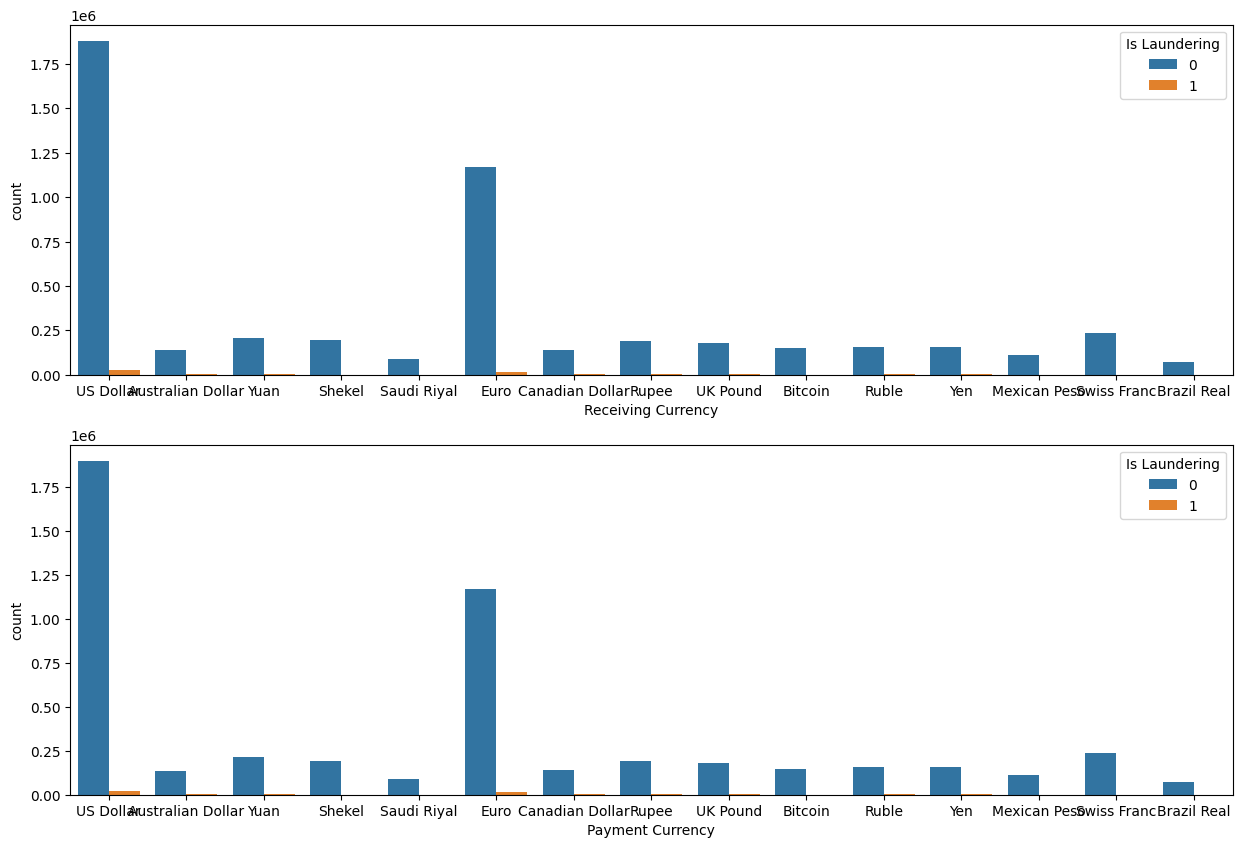

In [52]:
#Plot Categorical VS Target
cate = ["Receiving Currency","Payment Currency"]

fig, axes = plt.subplots(2,1,figsize=(15,10))
for cat, ax in zip(cate, axes.flatten()) :
  sns.countplot(x=cat,data=df,hue="Is Laundering",ax=ax)

Insight: The visualization above is one of the most important when further exploring the data. From this visualization, we can compare the number of money laundering transactions and non-money laundering transactions with the payment currencies they use. It is clear that almost all transactions that are NOT MONEY LAUNDERING (blue bars) use US Dollars as their payment currency. There are only a very few non-money laundering transactions that do not use US Dollars as their payment currency.

However, attention should also be given to the payment currencies used by MONEY LAUNDERING PERPETRATORS (orange bars). Most of them use payment currencies that are spread across various currencies, not just US Dollars, but also Euro, Yuan, UK Pound, and other currencies, which far exceeds the usage in non-money laundering transactions. This indicates that money laundering perpetrators are conducting transactions using currencies beyond just US Dollars, unlike the general population, and are using many currencies that are rarely used by ordinary people.

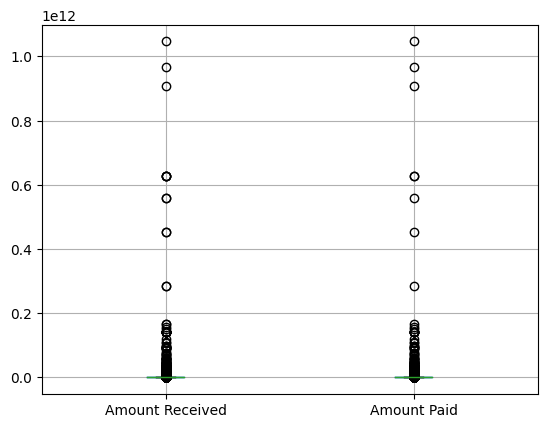

In [53]:
boxplot = df.boxplot(['Amount Received','Amount Paid'])

Insight: The boxplot visualization above is used to identify outliers that we previously identified. The circles with black borders represent outlier values that fall outside the boxplot. This indicates that there are 45 circles with black borders (outliers) where the Amount Received and Amount Paid are significantly higher than most transactions made by ordinary people.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


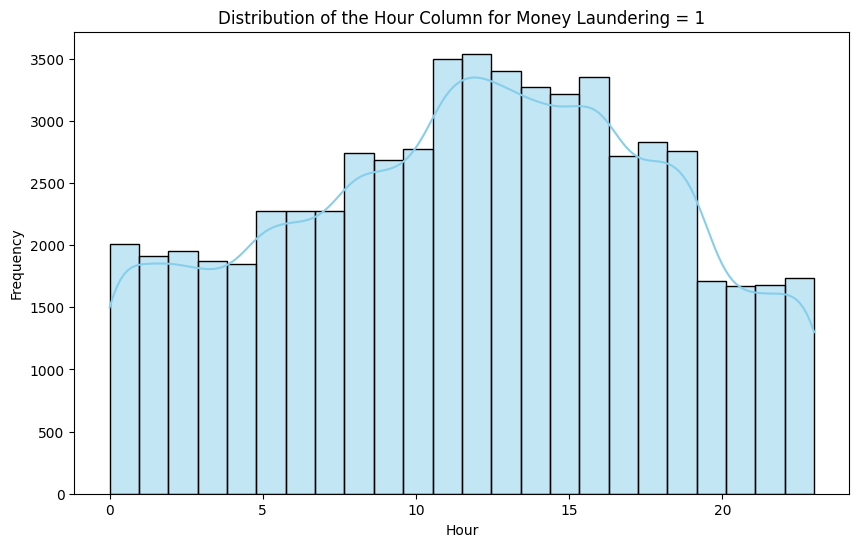

In [55]:
# Filter DataFrame to include only rows where 'Is Laundering' has a value of 1
df_is_laundering_1 = df[df['Is Laundering'] == 1]

# Creating a Histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_is_laundering_1, x='Hour', bins=24, kde=True, color='skyblue')
plt.title('Distribution of the Hour Column for Money Laundering = 1')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.show()

Insight: Most money laundering perpetrators conduct their transactions during the day, around 11:00 AM to 3:00 PM.

In [ ]:
# Payment Format
f, ax = plt.subplots(figsize=(10,4))

sns.countplot(x='Payment Format', data=df, ax=ax)
ax.set_title('Distribution of Payment Format')
ax.set_xlabel('Payment Format', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.tick_params(axis='x', labelrotation=45) # rotate x-axis labels

# Set the x-axis tick labels to the original values
# ax.set_xticklabels(df['Payment Format'].unique())

plt.show()

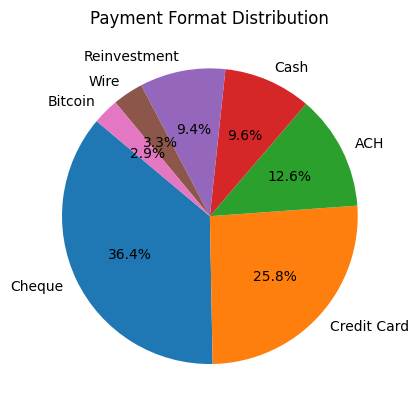

In [22]:
plt.pie(df['Payment Format'].value_counts(), labels=df['Payment Format'].value_counts().index, autopct='%1.1f%%', startangle=140)

plt.title('Payment Format Distribution')

plt.show()

#### **Check the number of transactions from each bank**

In [23]:
df['From Bank'].value_counts()

From Bank
70         458998
10          81670
12          80067
1           62414
15          52627
            ...  
1101523         1
327435          1
355782          1
1115265         1
2114062         1
Name: count, Length: 38812, dtype: int64

There are 1,23,511 different banks data are available here from where money is send.

In [24]:
df['To Bank'].value_counts()

To Bank
10        42615
12        42165
15        38813
220       30654
1         30289
          ...  
316415        1
342574        1
343063        1
348086        1
56928         1
Name: count, Length: 25527, dtype: int64

There are 65,915 different banks are available here to where money is send.

#### **Describe the From and To accounts**

In [25]:
df[['Account', 'Account.1']].describe()

,Account,Account.1
count,5133181,5133181
unique,532132,464719
top,100428660,100428660
freq,170196,1088


#### **Total counts of Laundering values**

In [26]:
df['Is Laundering'].value_counts()

Is Laundering
0    5073168
1      60013
Name: count, dtype: int64

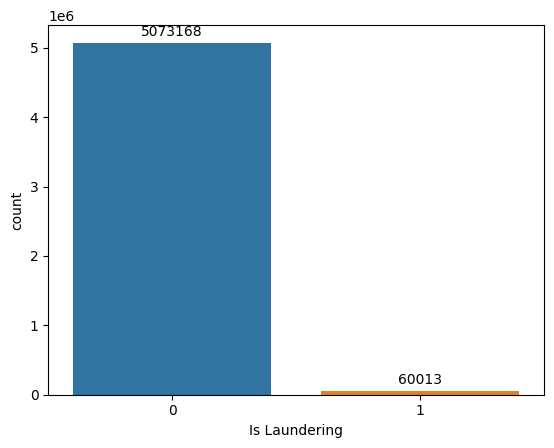

In [27]:
# Create the count plot
ax = sns.countplot(data=df, x='Is Laundering')

# Add count numbers on the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'baseline', 
                xytext = (0, 5), 
                textcoords = 'offset points')

# Show the plot
plt.show()

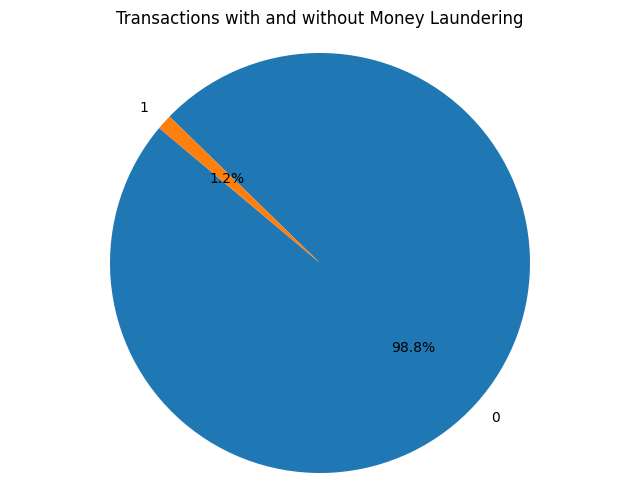

In [28]:
import matplotlib.pyplot as plt

laundering_counts = df['Is Laundering'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(laundering_counts, labels=laundering_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Transactions with and without Money Laundering')
plt.axis('equal')
plt.show()

In [29]:
laundering_df.shape

(60013, 11)

In [30]:
print("This is the total number of laundering transactions in different currencies:\n",currency_counts)

This is the total number of laundering transactions in different currencies:
 Payment Currency
US Dollar            23829
Euro                 16219
Yuan                  4007
UK Pound              2297
Ruble                 2138
Yen                   1905
Rupee                 1756
Australian Dollar     1408
Canadian Dollar       1297
Shekel                1111
Saudi Riyal            980
Swiss Franc            954
Mexican Peso           759
Brazil Real            726
Bitcoin                627
Name: count, dtype: int64


/tmp/ipykernel_33/3022132148.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  money_laundering_df['Timestamp'] = pd.to_datetime(money_laundering_df['Timestamp'])
/tmp/ipykernel_33/3022132148.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  money_laundering_df['Day'] = money_laundering_df['Timestamp'].dt.day


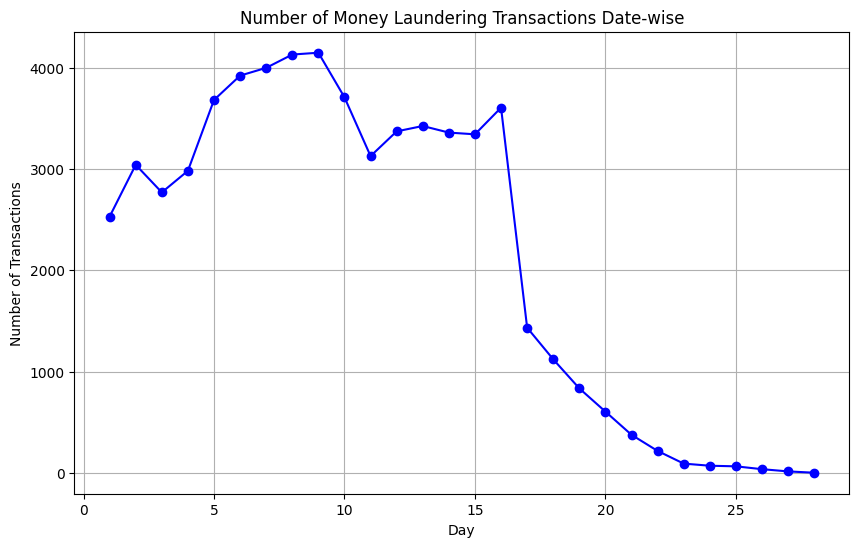

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing transaction data

# Step 1: Filter money laundering data
money_laundering_df = df[df['Is Laundering'] == 1]

# Step 2: Convert Timestamp column to datetime
money_laundering_df['Timestamp'] = pd.to_datetime(money_laundering_df['Timestamp'])

# Step 3: Extract year from Timestamp
money_laundering_df['Day'] = money_laundering_df['Timestamp'].dt.day

# Step 4: Count number of transactions for each year
transactions_by_year = money_laundering_df.groupby('Day').size()

# Step 5: Visualize the number of transactions year-wise
transactions_by_year.plot(kind='line', marker='o', color='b', figsize=(10, 6))
plt.title('Number of Money Laundering Transactions Date-wise')
plt.xlabel('Day')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

### **Check for Outliers** 

An outlier is data that deviates extremely (far) from the average of a dataset. In practice, outliers usually need to be treated specially. Generally, there are two common ways to handle outliers: either by removing them or by replacing them with the mean/average/mode of the dataset. First, let's identify which data points are recognized as outliers.

One method to identify and gather outliers is by searching for data that is either smaller than the mean minus (3 standard deviations) or larger than the mean plus (3 standard deviations). The method below can identify whether a transaction has an outlier value in the 'Amount Received' column or not.

In [32]:
#Identification of Outlier Values
mean = df['Amount Received'].mean()
std = df['Amount Received'].std()
Tmin = mean - (3 * std)
Tmax = mean + (3 * std)

# Display values from the 'Amount Received' column that are less than Tmin or greater than Tmax
filtered_values = df[(df['Amount Received'] < Tmin) | (df['Amount Received'] > Tmax)]['Amount Received'].values
print(filtered_values)

[4.01607074e+09 4.19789523e+09 9.66475957e+09 ... 6.28440160e+09
 4.05065398e+09 1.11334744e+10]


In [33]:
# Viewing the number of data points identified by filtered_values
number_of_identified_data_points = len(filtered_values)
print("Number of data points identified as Outliers:", number_of_identified_data_points)

Number of data points identified as Outliers: 1171


Once we have identified which data points are outliers, the next step is to decide on the special treatment for these outliers (ignore/remove/manipulate). We deliberately chose not to immediately remove the outlier values because we suspect that money laundering perpetrators might receive amounts from source accounts that are unusual or extremely deviating from the average of most people.

To determine what action is reasonable for outliers in this money laundering case, we need to examine how many of the outliers are identified as money laundering and how many are not identified as money laundering.

In [34]:
# Display data that matches in DataFrame format
outliers_dataframe = df[(df['Amount Received'] < Tmin) | (df['Amount Received'] > Tmax)]

# Display the number of unique values in the 'Is Laundering' column from the DataFrame outliers_dataframe
count_is_laundering = outliers_dataframe['Is Laundering'].value_counts()
print("Count of each unique value in the 'Is Laundering' column:\n", count_is_laundering)

Count of each unique value in the 'Is Laundering' column:
 Is Laundering
0    1114
1      57
Name: count, dtype: int64


In [35]:
df[df['Amount Received'].isin(filtered_values)]

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
1521,2022/09/09 04:22,1,801227860,4,806ABFC50,4.016071e+09,Ruble,4.016071e+09,Ruble,Cheque,0
13043,2022/09/10 23:58,1729,8005B6EF0,10813,80473AB10,4.197895e+09,Yen,4.197895e+09,Yen,Cheque,0
16096,2022/09/02 16:11,1411,8015D5A40,1411,8015D5A40,9.664760e+09,Ruble,1.242193e+08,US Dollar,ACH,0
16165,2022/09/09 13:30,29467,8036A13B0,15,8039C3FB0,9.078766e+09,Yen,9.078766e+09,Yen,Cheque,0
17040,2022/09/01 00:27,110057,8044D6310,110057,8044D6310,1.079765e+10,Yen,1.079765e+10,Yen,Reinvestment,0
...,...,...,...,...,...,...,...,...,...,...,...
5122559,2022/09/05 09:45,4523,805FF33D0,4523,805FF33D0,8.166714e+09,Yen,7.748306e+07,US Dollar,ACH,0
5122902,2022/09/09 00:24,13145,8024363D0,217125,80646F230,4.050654e+09,Ruble,4.050654e+09,Ruble,Cheque,0
5124503,2022/09/05 05:27,29467,8039DA070,19925,804515E00,6.284402e+09,Yen,6.284402e+09,Yen,Cheque,0
5128100,2022/09/08 19:18,13145,8024363D0,217125,80646F230,4.050654e+09,Ruble,4.050654e+09,Ruble,Cheque,0


### **Feature Selection and Manipulation**

As we know, Machine Learning can only process numerical data. Therefore, it is important for us to wisely select the features available. When there are features that cannot be processed, we need to manipulate them to produce meaningful values.

Based on the data information above, there are several columns that are not of numerical data type:

- Timestamp

- Account

- Account.1

- Receiving Currency

- Payment Currency

- Payment Format

In [36]:
# check data atribute
df.columns

Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering'],
      dtype='object')

We began by manipulating the 'Timestamp' column. The 'Timestamp' column is an object-type column that stores data in the format Year/Month/Day/Hour/Minute of a transaction. We manipulated the 'Timestamp' column by extracting only the hour and minute into new columns named 'Hour' and 'Minutes', both of integer type.

This was done not without reason, as we suspect that money laundering activities may occur at specific times. Therefore, we converted the 'Timestamp' column, which was initially of object type, to a datetime type.

Once the system recognized the 'Timestamp' column as a datetime type, we created new columns ('Hour' and 'Minutes') to store the hour and minute from the 'Timestamp' column. As a result, the 'Timestamp' column became irrelevant, so we decided to drop it.

In [37]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Access hour and minute attributes using 'dt'
df['Hour'] = df['Timestamp'].dt.hour
df['Minutes'] = df['Timestamp'].dt.minute

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5133181 entries, 0 to 5133180
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Timestamp           datetime64[ns]
 1   From Bank           int64         
 2   Account             object        
 3   To Bank             int64         
 4   Account.1           object        
 5   Amount Received     float64       
 6   Receiving Currency  object        
 7   Amount Paid         float64       
 8   Payment Currency    object        
 9   Payment Format      object        
 10  Is Laundering       int64         
 11  Hour                int32         
 12  Minutes             int32         
dtypes: datetime64[ns](1), float64(2), int32(2), int64(3), object(5)
memory usage: 470.0+ MB


In [39]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Hour,Minutes
0,2022-09-05 12:02:00,70,100428660,2843,8013F24E0,297.20,US Dollar,297.20,US Dollar,Credit Card,0,12,2
1,2022-09-01 17:31:00,2133655,832677D20,2117586,832677DC0,895.55,Australian Dollar,895.55,Australian Dollar,ACH,1,17,31
2,2022-09-01 20:44:00,5627,802F9AD90,19705,8080AA370,1643.93,Yuan,1643.93,Yuan,Cheque,0,20,44
3,2022-09-01 08:34:00,22828,802438240,11157,805CDE900,181265.98,US Dollar,181265.98,US Dollar,Cheque,0,8,34
4,2022-09-09 12:13:00,28222,80A5CB130,127593,80A738EB0,234.99,Australian Dollar,234.99,Australian Dollar,Credit Card,0,12,13


In [40]:
#Drop unrelatable columns
df = df.drop(columns=['Timestamp'])

After manipulating the 'Timestamp' column, we turned our attention to the next features, 'Account' and 'Account.1', where 'Account' represents the hexadecimal code of the source transaction account, and 'Account.1' represents the hexadecimal code of the destination transaction account. In this process, we want to determine if there is an effect if a transaction is made from an account to the same account concerning the identification of money laundering transactions.

Therefore, we created a new column named 'Different Account', which will have a value of 0 if the transaction is made to the same account as the sender's account, and a value of 1 if the transaction is made to a different account from the sender's account. After creating the 'Different Account' column, the 'Account' and 'Account.1' columns become irrelevant and can be dropped.

In [41]:
df['Different Account'] = np.where(df['Account'] == df['Account.1'], 0, 1)

In [42]:
df.tail()

,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Hour,Minutes,Different Account
5133176,1024,801C2F650,25768,8022B0FC0,7446920.37,Euro,7446920.37,Euro,Cheque,0,21,39,1
5133177,210292,804642E50,210292,804642E50,455.79,Yen,455.79,Yen,Reinvestment,0,17,23,0
5133178,2824,8033F1A70,23842,80726B3D0,3902.64,US Dollar,3902.64,US Dollar,Cheque,0,16,8,1
5133179,21745,801555420,27217,811778B10,1876.62,Euro,1876.62,Euro,Cheque,0,11,58,1
5133180,4726,8061D2DB0,3242,809530890,20245349.24,US Dollar,20245349.24,US Dollar,ACH,0,10,40,1


In [43]:
#view the number of data entries in the 'Different Account' column
df['Different Account'].value_counts()

Different Account
1    4541884
0     591297
Name: count, dtype: int64

Here 1 represents, money is transferred to different account, and 0 represents money is transferred to the same account.

In [44]:
count_1_0 = df[(df['Different Account'] == 1) & (df['Is Laundering'] == 0)]['Is Laundering'].count()
count_0_1 = df[(df['Different Account'] == 0) & (df['Is Laundering'] == 1)]['Is Laundering'].count()
count_1_1 = df[(df['Different Account'] == 1) & (df['Is Laundering'] == 1)]['Is Laundering'].count()
count_0_0 = df[(df['Different Account'] == 0) & (df['Is Laundering'] == 0)]['Is Laundering'].count()

# Displaying the results
print("Total (Different Account=1, Is Laundering=0):", count_1_0)
print("Total (Different Account=0, Is Laundering=1):", count_0_1)
print("Total (Different Account=1, Is Laundering=1):", count_1_1)
print("Total (Different Account=0, Is Laundering=0):", count_0_0)

Total (Different Account=1, Is Laundering=0): 4481967
Total (Different Account=0, Is Laundering=1): 96
Total (Different Account=1, Is Laundering=1): 59917
Total (Different Account=0, Is Laundering=0): 591201


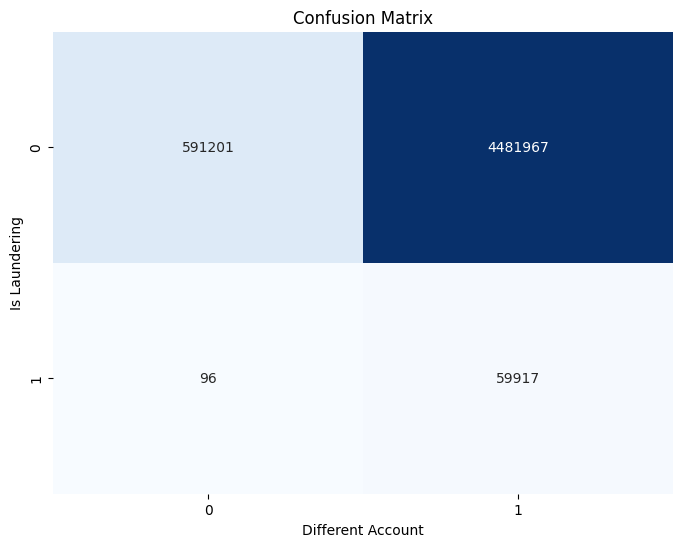

In [46]:
from sklearn.metrics import confusion_matrix

# Creating a confusion matrix
conf_matrix = confusion_matrix(df['Is Laundering'], df['Different Account'])

# Visualizing the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Different Account')
plt.ylabel('Is Laundering')
plt.show()

Initially, we assumed that a transaction occurring from the same account to the same account would be unusual. However, after performing the calculations, it turned out that the impact of transactions from the same account to the same account on identifying money laundering was not very strong. This is based on the confusion matrix, which evaluated the influence of the 'Different Account' column on the 'Is Laundering' column, showing relatively balanced values. There were only 96 instances where a transaction occurred from the same account to the same account and was identified as money laundering. This number is relatively small compared to the others.

In [47]:
#Drop unrelatable columns
df = df.drop(columns=['Account','Account.1'])

In [48]:
df.head()

,From Bank,To Bank,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Hour,Minutes,Different Account
0,70,2843,297.20,US Dollar,297.20,US Dollar,Credit Card,0,12,2,1
1,2133655,2117586,895.55,Australian Dollar,895.55,Australian Dollar,ACH,1,17,31,1
2,5627,19705,1643.93,Yuan,1643.93,Yuan,Cheque,0,20,44,1
3,22828,11157,181265.98,US Dollar,181265.98,US Dollar,Cheque,0,8,34,1
4,28222,127593,234.99,Australian Dollar,234.99,Australian Dollar,Credit Card,0,12,13,1


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5133181 entries, 0 to 5133180
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   From Bank           int64  
 1   To Bank             int64  
 2   Amount Received     float64
 3   Receiving Currency  object 
 4   Amount Paid         float64
 5   Payment Currency    object 
 6   Payment Format      object 
 7   Is Laundering       int64  
 8   Hour                int32  
 9   Minutes             int32  
 10  Different Account   int64  
dtypes: float64(2), int32(2), int64(4), object(3)
memory usage: 391.6+ MB


## **Feature Engineering**
**Our goal in examining the variation in categorical data above is to determine the appropriate feature engineering for each categorical column. As is known, Machine Learning can only process numeric data, so categorical data must be converted into numeric data through feature engineering. Feature engineering includes several methods such as:**

- **Binary Encoding (for converting categorical data with only 2 unique values)**
- **One Hot Encoding (for converting categorical data with more than 2 unique values)**
- **Label Encoding (for converting categorical data into labels that we define)**
- **Frequency Encoding (for converting categorical data into numeric values based on the frequency of each value)**
- **Mean Encoding (for converting categorical data into numeric values based on the mean)**

**NOTES: It is crucial for us to wisely choose the most suitable method for each categorical column.**

In [56]:
df.head()

,From Bank,To Bank,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Hour,Minutes,Different Account
0,70,2843,297.20,US Dollar,297.20,US Dollar,Credit Card,0,12,2,1
1,2133655,2117586,895.55,Australian Dollar,895.55,Australian Dollar,ACH,1,17,31,1
2,5627,19705,1643.93,Yuan,1643.93,Yuan,Cheque,0,20,44,1
3,22828,11157,181265.98,US Dollar,181265.98,US Dollar,Cheque,0,8,34,1
4,28222,127593,234.99,Australian Dollar,234.99,Australian Dollar,Credit Card,0,12,13,1


For the 'Payment Currency' and 'Receiving Currency' columns, we agreed to use frequency encoding. The reason is that the data has considerable variation (with 15 unique values), making binary encoding unsuitable and one-hot encoding potentially burdensome. Additionally, we chose frequency encoding because we want to replace a value with how frequently it appears compared to other unique values.

In [57]:
#Create a Frequency Encoding Function
def frequency_encoding(data,features) :
    freq_encoding=data.groupby(features).size()/len(data)
    return freq_encoding

In [58]:
df['Payment Currency'] = df['Payment Currency'].map(frequency_encoding(df,df['Payment Currency']))

In [59]:
df['Receiving Currency'] = df['Receiving Currency'].map(frequency_encoding(df,df['Receiving Currency']))

For the 'Payment Format' column, we agreed to use one-hot encoding as the feature engineering method because the number of unique values in the 'Payment Format' column is only 7, which is manageable and won't overly burden the machine learning model building process.

In [60]:
#One hot encoding For Payment Format
df = pd.get_dummies(df,columns=['Payment Format'])

In [61]:
df.head()

,From Bank,To Bank,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Is Laundering,Hour,Minutes,Different Account,Payment Format_ACH,Payment Format_Bitcoin,Payment Format_Cash,Payment Format_Cheque,Payment Format_Credit Card,Payment Format_Reinvestment,Payment Format_Wire
0,70,2843,297.20,0.370386,297.20,0.373470,0,12,2,1,False,False,False,False,True,False,False
1,2133655,2117586,895.55,0.027233,895.55,0.026894,1,17,31,1,True,False,False,False,False,False,False
2,5627,19705,1643.93,0.040983,1643.93,0.042386,0,20,44,1,False,False,False,True,False,False,False
3,22828,11157,181265.98,0.370386,181265.98,0.373470,0,8,34,1,False,False,False,True,False,False,False
4,28222,127593,234.99,0.027233,234.99,0.026894,0,12,13,1,False,False,False,False,True,False,False


In [63]:
df.shape

(5133181, 17)

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5133181 entries, 0 to 5133180
Data columns (total 17 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   From Bank                    int64  
 1   To Bank                      int64  
 2   Amount Received              float64
 3   Receiving Currency           float64
 4   Amount Paid                  float64
 5   Payment Currency             float64
 6   Is Laundering                int64  
 7   Hour                         int32  
 8   Minutes                      int32  
 9   Different Account            int64  
 10  Payment Format_ACH           bool   
 11  Payment Format_Bitcoin       bool   
 12  Payment Format_Cash          bool   
 13  Payment Format_Cheque        bool   
 14  Payment Format_Credit Card   bool   
 15  Payment Format_Reinvestment  bool   
 16  Payment Format_Wire          bool   
dtypes: bool(7), float64(4), int32(2), int64(4)
memory usage: 386.7 MB


### **Splitting Dataset**
Next, we begin the development of this machine learning model by performing dataset splitting. The purpose of this splitting is to allocate a portion of the data for training our machine learning model and another portion for testing the model to evaluate its accuracy. In this case, we have decided to split the data into 80% for training and 20% for testing.

In [66]:
from sklearn.model_selection import train_test_split

#spliting dataset
X = df.drop(columns="Is Laundering")
y = df['Is Laundering']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify=y,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4106544, 16), (1026637, 16), (4106544,), (1026637,))

### **Logistic Regression Model (Default)**
**Since in this money laundering case we aim to predict whether a transaction falls into the money laundering category or not, the model we are developing is a classification model. The goal is for the model to classify whether a transaction is categorized as money laundering or not. The first model we are building is a Logistic Regression model.**

In [67]:
# Import library
from sklearn.linear_model import LogisticRegression

# Train data dengan data training
model_log = LogisticRegression()
model_log.fit(X_train,y_train)

LogisticRegression()

In [68]:
# Viewing the accuracy of the model
model_log.score(X_test,y_test)

0.9881603721665984

In [70]:
y_predict_log=model_log.predict(X_test)

In [71]:
# Displaying the report to evaluate the model's performance

from sklearn.metrics import classification_report
print('\nLogistic Regression Classification Report (Default)\n')
print(classification_report(y_test, y_predict_log))


Logistic Regression Classification Report (Default)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1014634
           1       0.00      0.00      0.00     12003

    accuracy                           0.99   1026637
   macro avg       0.49      0.50      0.50   1026637
weighted avg       0.98      0.99      0.98   1026637



### **LR Model Improvement : Parameter Tuning**
The Logistic Regression model above is far from optimal as it has an accuracy of 0%. Therefore, we are attempting to perform parameter tuning with GridSearchCV to find which parameters are best used to achieve the highest accuracy. The parameters are 'penalty' and 'C'.

In [72]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# Tentukan parameter apa saja yang akan dituning
parameters = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
}

# Inisialisasi model Logistic Regression
modelLogReg = LogisticRegression()

# Gunakan GridSearchCV untuk mencari parameter terbaik
grid_search_logreg = GridSearchCV(modelLogReg, param_grid=parameters, scoring='accuracy', cv=5)
grid_search_logreg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [73]:
# Display the best parameters that can achieve the maximum accuracy produced by the Logistic Regression model
print("Tuned Hyperparameters :", grid_search_logreg.best_params_)
print("Accuracy :",grid_search_logreg.best_score_)

Tuned Hyperparameters : {'C': 0.1, 'penalty': 'l2'}
Accuracy : 0.9881550033227858


In [74]:
#Train data with the Best Parameters
modellog_best = LogisticRegression(C = 0.001, penalty = 'l2')
modellog_best.fit(X_train,y_train)

LogisticRegression(C=0.001)

#### **Logistic Regression Evaluation Matrix**

In [75]:
#testing
y_predict_bestlog = modellog_best.predict(X_test)

In [76]:
print('\nLogistic Regression Classification Report (Tuned)\n')
print(classification_report(y_test, y_predict_bestlog))


Logistic Regression Classification Report (Tuned)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1014634
           1       0.00      0.00      0.00     12003

    accuracy                           0.99   1026637
   macro avg       0.49      0.50      0.50   1026637
weighted avg       0.98      0.99      0.98   1026637



### **Naive Bayes Model (Default)**
Although the Logistic Regression model above has been optimized with parameter tuning, its accuracy is still well below (0%). Therefore, we conclude that in this case, we cannot use the Logistic Regression model. We will continue searching for the best model with Naive Bayes.

In [77]:
# Import library
from sklearn.naive_bayes import MultinomialNB

# Training Model
model_nb =MultinomialNB()
model_nb.fit(X_train, y_train)

MultinomialNB()

In [78]:
# View Model Accuracy
model_nb.score(X_test,y_test)

0.9235523364149159

In [79]:
# Testing
y_predict_nb=model_nb.predict(X_test)

In [80]:
from sklearn.metrics import classification_report
print('\nNaive Bayes Classification Report (Default)\n')
print(classification_report(y_test, y_predict_nb))


Naive Bayes Classification Report (Default)

              precision    recall  f1-score   support

           0       0.99      0.93      0.96   1014634
           1       0.01      0.05      0.01     12003

    accuracy                           0.92   1026637
   macro avg       0.50      0.49      0.49   1026637
weighted avg       0.98      0.92      0.95   1026637



### **NB Model Improvement: Parameter Tuning**

The model only provides an accuracy of 0.01% in predicting whether a transaction falls into the money laundering category or not. We still want to try to maximize our Naive Bayes model through parameter tuning using GridSearchCV. We will perform tuning with the alpha parameter in the Naive Bayes model.

In [81]:
# Import Library
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# Define the parameter grid for Multinomial Naive Bayes
parameters = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
}


modelNB = MultinomialNB()

# Gunakan GridSearchCV untuk mencari parameter terbaik
grid_search_nb = GridSearchCV(modelNB, param_grid=parameters, scoring='accuracy', cv=5)
grid_search_nb.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='accuracy')

In [82]:
# Display the best parameters and their maximum accuracy

print("Tuned Hyperparameters :", grid_search_nb.best_params_)
print("Accuracy :",grid_search_nb.best_score_)

Tuned Hyperparameters : {'alpha': 0.001}
Accuracy : 0.9231392632890227


In [83]:
# Train the data with the best parameters
modelnb_best = MultinomialNB(alpha = 0.001)
modelnb_best.fit(X_train,y_train)

MultinomialNB(alpha=0.001)

### **Naive Bayes Evaluation Matrix**

In [84]:
y_predict_bestnb = modelnb_best.predict(X_test)

In [85]:
print('\nNaive Bayes Classification Report (Tuned)\n')
print(classification_report(y_test, y_predict_bestnb))


Naive Bayes Classification Report (Tuned)

              precision    recall  f1-score   support

           0       0.99      0.93      0.96   1014634
           1       0.01      0.05      0.01     12003

    accuracy                           0.92   1026637
   macro avg       0.50      0.49      0.49   1026637
weighted avg       0.98      0.92      0.95   1026637



### **K-Nearest Neighbor Model (Default)**

After optimizing our Naive Bayes model, we still have not found a model with sufficiently high accuracy to predict the 'Is Laundering' label. Therefore, we are trying the KNN model.

In [2]:
# Import library
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')

# Train the model with the training data
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train,y_train)

NameError: name 'X_train' is not defined

In [1]:
# Evaluate the accuracy of KNN with the testing data
print('KNN Default Accuracy :')
knn.score(X_test,y_test)

KNN Default Accuracy :


NameError: name 'knn' is not defined